# Image classification with transfer learning

In [3]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

#Importing dataset from CIFAR
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split


# Load CIFAR-10 dataset.
# We are naming the test part as holdout for now so that we can later split it into validation and test data.
(x_train, y_train), (x_holdout, y_holdout) = cifar10.load_data()

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(y_train.shape[0], "train labels")
print(x_holdout.shape[0], "test samples")
print(y_holdout.shape[0], "test labels")

x_train shape: (50000, 32, 32, 3)
50000 train samples
50000 train labels
10000 test samples
10000 test labels


In [3]:
#Holding out data for test validation, ensuring a consistent split across classes with stratify
# We are getting 50% of the holdout data (test_size=0.50), which was already 20% of the entire dataset.

x_test, x_val, y_test, y_val = train_test_split(
    x_holdout, y_holdout, test_size=0.50, stratify=y_holdout, random_state=42
)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validation samples")
print(x_test.shape[0], "test samples")

x_train shape: (50000, 32, 32, 3)
50000 train samples
5000 validation samples
5000 test samples


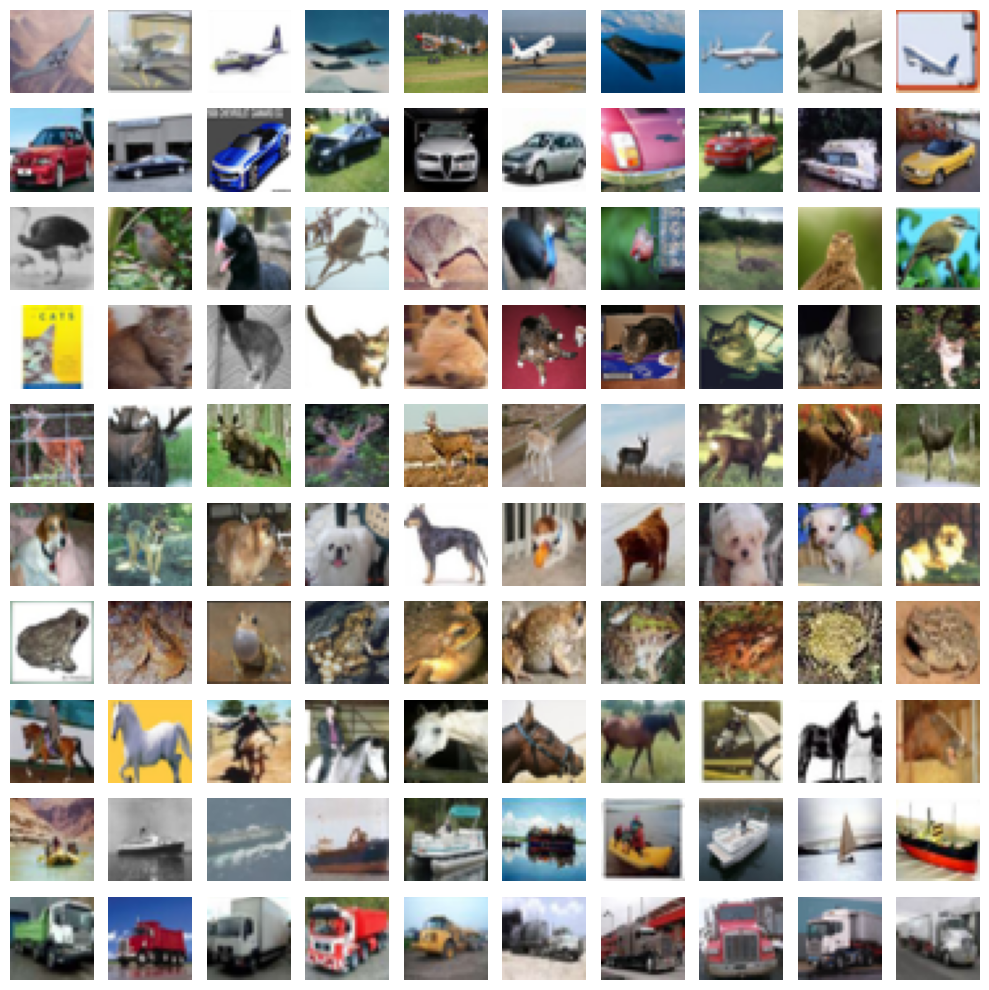

In [4]:
#Visualize: 10×10 grid, 10 random samples per class to make sure we have all classes represented
import matplotlib.pyplot as plt

class_names = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]
y_val_f = y_val.flatten()
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for cls in range(10):
    idxs = np.where(y_val_f == cls)[0]
    sel = np.random.choice(idxs, 10, replace=False)
    for j, idx in enumerate(sel):
        ax = axes[cls, j]
        ax.imshow(x_val[idx])
        ax.axis("off")
plt.tight_layout()
plt.show()

In [5]:
"""
## Prepare the data
"""

# Model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_val = x_val.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [6]:
# convert classes into categories
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)

In [ ]:
##block of code used to clear keras sessions during development

#from keras.backend import clear_session
#clear_session()

## Transfer Learning implementation

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import


Re-scaling pixel values for TL

In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

IMG_SHAPE = (32,32,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')



/tmp/ipython-input-3897582453.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [19]:
base_model.trainable = False

In [21]:
#Add a classification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(x_train)
print(feature_batch_average.shape)

(50000, 3)


In [22]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(50000, 1)


In [31]:
#data_augmentation = tf.keras.Sequential([
#    tf.keras.layers.RandomFlip('horizontal'),
#    tf.keras.layers.RandomRotation(0.2),
#])


inputs = tf.keras.Input(shape=(32, 32, 3))
#x = data_augmentation(x_train)
x = preprocess_input(x_train)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

InternalError: Exception encountered when calling Functional.call().

[1mFailed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.[0m

Arguments received by Functional.call():
  • inputs=array([[[[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        ...,

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]]],


       [[[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        ...,

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]]],


       [[[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        ...,

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]]],


       ...,


       [[[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        ...,

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]]],


       [[[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        ...,

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]]],


       [[[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        ...,

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]],

        [[-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         ...,
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051],
         [-1.0079051, -1.0079051, -1.0079051]]]], dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [32]:
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

ResourceExhaustedError: Exception encountered when calling Rescaling.call().

[1m{{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: [0m

Arguments received by Rescaling.call():
  • inputs=tf.Tensor(shape=(50000, 32, 32, 3), dtype=float32)